In [33]:
import torch
import numpy as np
import cv2

from matplotlib import pyplot as plt
from PIL import Image

import torchvision
from torchvision import transforms
from torchvision import models
from torch.autograd import Variable

In [34]:
## 보트일때
#input_image = Image.open('./examples/fireboat.jpg')
#index_image = 555

## 판다일때
input_image = Image.open('./examples/panda.jpeg')
index_image = 389

### 원래 이미지 fireboat

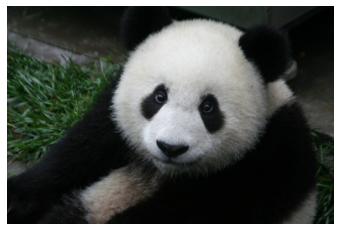

In [35]:
plt.axis('off')
plt.imshow(input_image)

In [36]:
model = models.inception_v3(pretrained=True)
model.eval()

preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
print(input_tensor.shape)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

torch.Size([3, 299, 299])


In [37]:
with torch.no_grad():
  output = model(input_batch)    

probabilities = torch.nn.functional.softmax(output[0], dim=0)

with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
    
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

giant panda 0.936522364616394
soccer ball 0.0015114177949726582
teddy 0.000713529996573925
space shuttle 0.0005871425964869559
lesser panda 0.00046196483890525997


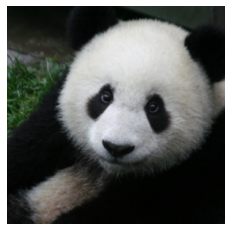

In [38]:
plt.axis('off')
plt.imshow(input_tensor.permute(1,2,0))

In [39]:
m_steps = 300
alphas = torch.linspace(start=0, end=1, steps=m_steps)
alphas.shape

torch.Size([300])

In [40]:
baseline = torch.zeros(size=(3,299,299))

In [41]:
def interpolate_images(baseline,
                      image,
                      alphas):
    alphas_x = alphas[:, np.newaxis, np.newaxis, np.newaxis]
    baseline_x = torch.unsqueeze(baseline, 0)
    input_x = torch.unsqueeze(image, 0)
    delta = input_x - baseline_x
    image = baseline_x + alphas_x * delta
    
    
    return image

In [42]:
interpolated_images = interpolate_images(
    baseline=baseline,
    image=input_tensor,
    alphas=alphas)

interpolated_images.shape

torch.Size([300, 3, 299, 299])

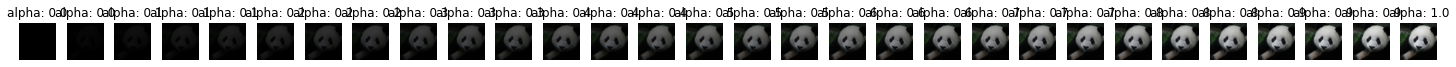

In [43]:
fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
  i += 1
  plt.subplot(1, len(alphas[0::10]), i)
  plt.title(f'alpha: {alpha:.1f}')
  plt.imshow(image.permute(1,2,0))
  plt.axis('off')

plt.tight_layout();

In [44]:
def compute_gradients(images, target_class_idx):
    
    gradients = torch.empty(size=(0,3,299,299))
    gradients = gradients.cuda()
    empty = False

    for i in range(len(images)):
        
        images = images.cuda()
        integrated_input = images[i].requires_grad_(True)
        integrated_output = model(integrated_input.unsqueeze(0))
        integrated_output[:,target_class_idx].backward()
        gradient = integrated_input.grad.data
        gradient = gradient.unsqueeze(0)
        if empty == False:
            gradients = torch.cat([gradients,gradient],0)
            #print("11")
            #print(gradients.shape)
            empty = True
        else:
            #print("22")
            gradients = torch.cat([gradients,gradient])
            #print(gradients.shape)
            
    return gradients

In [45]:
gradients = compute_gradients(interpolated_images, index_image)
gradients = gradients.mean(dim=0)
#gradients = gradients.cuda

In [46]:
step1 = (input_tensor - baseline).cuda()
step2 = step1 * gradients
step2 = torch.tensor(step2.cpu().data.numpy())

In [47]:
IG_image = torch.sum(torch.abs(step2),dim=0)

(-0.5, 298.5, 298.5, -0.5)

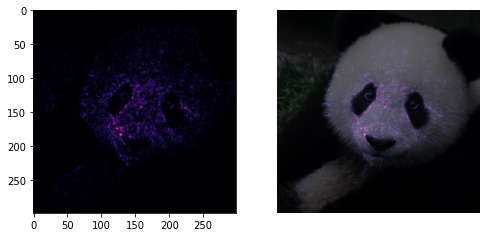

In [51]:
fig, axs = plt.subplots(nrows=1, ncols=2, squeeze=False, figsize=(8, 8))

axs[0, 0].imshow(IG_image, cmap=plt.cm.inferno)
axs[0, 1].axis('off')

axs[0, 1].imshow(IG_image, cmap=plt.cm.inferno)
axs[0, 1].imshow(input_tensor.permute(1,2,0), alpha=0.4)
axs[0, 1].axis('off')